In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('Credit Card_Clustering.csv')
data.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

In [4]:
# impute the missing values in numerical column using KNN technique
from sklearn.impute import KNNImputer
columns_with_missing = ['MINIMUM_PAYMENTS', 'CREDIT_LIMIT']

imputer = KNNImputer(n_neighbors=5)

data[columns_with_missing] = imputer.fit_transform(data[columns_with_missing])

In [5]:
# drop CUST_ID because its a uniquie identifier, it will help our model.
data = data.drop(columns=['CUST_ID'], axis=1)

In [6]:
from sklearn.preprocessing import normalize

data_norm = normalize(data)

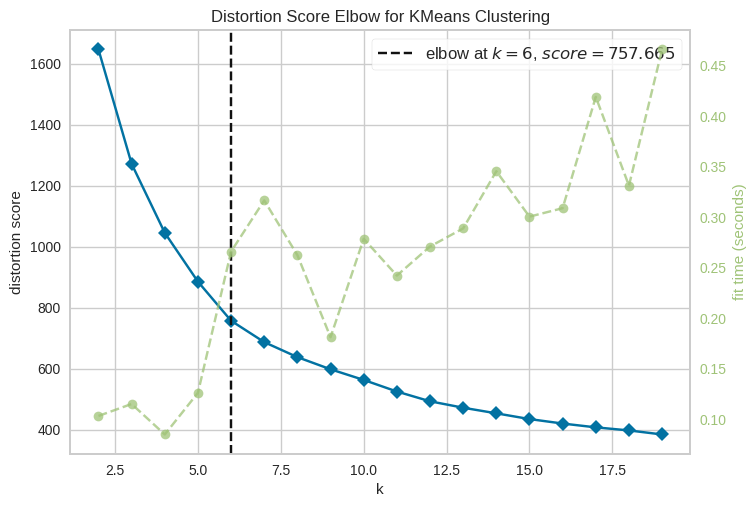

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [7]:
# using yellobrick api to get the optimal k value for the model
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

kmeans = KMeans(n_init=10)

vis = KElbowVisualizer(kmeans, k=(2, 20))
vis.fit(data_norm)
vis.show()

In [9]:
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score

param_grid = {
    'n_clusters': [2, 3, 4, 5, 6, 7, 8, 9]  # Specify the number of clusters you want to try
}

k_mean = KMeans(n_init=10)

# Define a custom scoring function using silhouette score

def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    score = silhouette_score(X, labels)
    return score

grid_search = GridSearchCV(kmeans, param_grid, cv=5, scoring=silhouette_scorer)
grid_search.fit(data_norm)
# Print the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'n_clusters': 6}
Best Score: 0.3662412134931147


In [10]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
kmeans.fit(data_norm)


KMeans(n_clusters=6, n_init=10, random_state=42)

In [11]:
labels = kmeans.fit_predict(data_norm)
labels

array([0, 4, 0, ..., 0, 0, 1], dtype=int32)

In [12]:
from sklearn.metrics import silhouette_score

# Evaluate clustering
silhouette_avg = silhouette_score(data_norm, labels)
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.3635299584763059


In [13]:
from sklearn.decomposition import PCA
# Reduce dimensions using PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_norm)

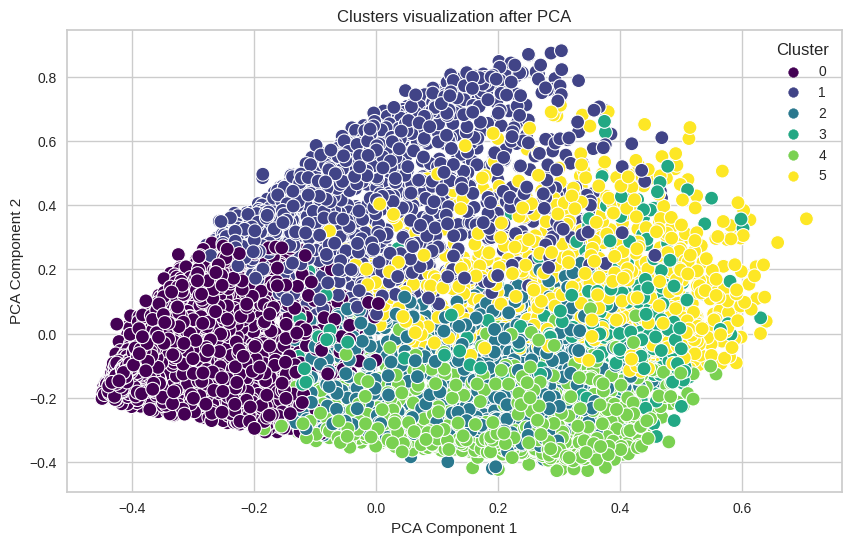

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=labels, palette='viridis', s=100)
plt.title('Clusters visualization after PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

In [16]:
# Convert normalized data back to DataFrame
data_norm_df = pd.DataFrame(data_norm, columns=data.columns)
# Add the cluster labels to the DataFrame
data_norm_df['cluster'] = labels

In [17]:
# Group by the cluster labels and compute the mean
cluster_summary = data_norm_df.groupby('cluster').mean()
print(cluster_summary)

          BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
cluster                                                             
0        0.066852           0.000232   0.123068          0.048730   
1        0.156147           0.000247   0.445770          0.261054   
2        0.562673           0.000302   0.084910          0.047094   
3        0.252452           0.000213   0.123208          0.024671   
4        0.371961           0.000229   0.041224          0.024019   
5        0.230678           0.000211   0.069353          0.038670   

         INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
cluster                                                              
0                      0.074442      0.019792             0.000172   
1                      0.184892      0.026883             0.000204   
2                      0.037854      0.103611             0.000090   
3                      0.098934      0.054270             0.000141   
4                      0.01